In [1]:
# HINTS with numpy
#%load_ext line_profiler
import numpy as np
from HINTS import *
from HINTS_fn_Student_t import *

%matplotlib inline
import matplotlib.pyplot as plt # just for testing

# Student t distribution

- overview https://en.wikipedia.org/wiki/Student%27s_t-distribution
- in scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html 

A 'non-standard' or 'location-scale' t distribution has the following params:

- &nu; (int >=1) degrees of freedom
- &mu; mean & mode
- &tau; scale parameter



0.9965458053084697  should approx. equal  1.0
1.1614197455050919  should approx. equal  1.1547005383792515


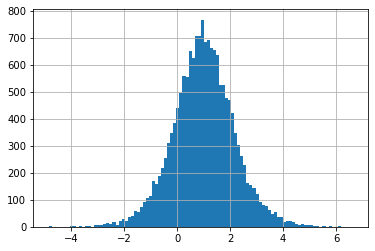

In [2]:
# generate some example data in numpy
mu = 1.0
tau = 1.0 # not the same as sigma because the standard t has variance nu/(nu-2), if this exists
nu = 8 # NB if wer choose low values of nu (dof) we get a very tight distribution
log2N = 14 # size of dataset
NX = 2 ** log2N


eg = mu + np.random.standard_t(nu, size = NX) * tau

print(np.mean(eg), " should approx. equal ", mu)
print(np.std(eg), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts, bins = np.histogram(eg, bins = 100)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.grid() # NB if we make nu smaller we get much fatter tails

0.9918377249339972  should approx. equal  1.0
1.1619439895734593  should approx. equal  1.1547005383792515


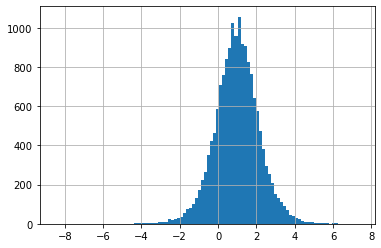

In [3]:
# scipy

np.random.seed(seed=4) # depending on seed, the max likelihood nu may or may not be the same as the nu we used

from scipy.stats import t # non central t

eg2 = t.rvs(nu, loc = mu, scale = tau, size = NX)

print(np.mean(eg2), " should approx. equal ", mu)
print(np.std(eg2), " should approx. equal ", np.sqrt(nu/(nu-2)))

counts2, bins2 = np.histogram(eg2, bins = 100)
_ = plt.hist(bins2[:-1], bins2, weights=counts2)
plt.grid() # NB if we make nu smaller we get much fatter tails

# all looks fine

In [4]:
# log likelihood example (it's not very sensitive to dof!)
print(nu)
mll = t(nu, loc = mu, scale = tau).logpdf(eg2).sum() # likelihood for actual params
print(mll) # actual
print("Neighbours - MLL: will usually be negative (less likely) ") 
print(t(nu-1, loc = mu, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu+1, loc = mu, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu - 0.05, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu + 0.05, scale = tau).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu, scale = tau * 1.05).logpdf(eg2).sum() - mll)
print(t(nu, loc = mu, scale = tau / 1.05).logpdf(eg2).sum() - mll)

# NB if we see -10, then it is exp(-10) less likely. So even with N = 10000, the posterior on DOF is very tight 

8
-25489.196478797254
Neighbours - MLL: will usually be negative (less likely) 
-3.7150665039007436
-5.470751554828894
-12.228713015985704
-21.14222245550627
-17.818551739175746
-39.46836741266452


In [5]:
%timeit t(nu, mu, tau) #656 micros  SCIPY is slow to construct objects
%timeit t(nu, mu, tau).logpdf(eg2[:1]) # 905 micros
%timeit t(nu, mu, tau).logpdf(eg2[:1000]) #1070 micros: SO IN REALITY WE WOULD DO BIG VECTOR EVALUATIONS (BUT NOT FOR TESTING HERE ... WOULD BE OVERCONFIDENT) 

644 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
880 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.09 ms ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:



x1 = StateT(nu, mu, tau)
print(x1)
print(x1.log_like(eg2)/len(eg2)) # should be same as above

print(proposalT(x1)[0])


Student t state variable: nu = 8,  mu = 1.000, tau = 1.000
-1.5557370897703402
Student t state variable: nu = 9,  mu = 0.954, tau = 0.992


In [7]:


# say we have NX = 2**14 datapoints: arrange as 1024 scenarios each with 16, or 256 by 64
# HINTS will have biggest advantage for small leaf size (mixing time in terms of leaf evals)

LEAF_SIZE = 64 ## vectorise at leaves for speed
NUM_SCENARIOS = NX//LEAF_SIZE
print(NUM_SCENARIOS, "scenarios by", LEAF_SIZE, "in each leaf =", NX, "(dataset size)")

data = t.rvs(nu, loc = mu, scale = tau, size = [NUM_SCENARIOS, LEAF_SIZE])
print(data.shape)



256 scenarios by 64 in each leaf = 16384 (dataset size)
(256, 64)


In [8]:
# CHECK CACHE IS WORKING

fn = TestFnT(data)

print(fn.counter)
%time fn(x1, list(range(NUM_SCENARIOS)))/(NUM_SCENARIOS * LEAF_SIZE) # check we get the right log likelihood
print(fn.counter)
%time fn(x1, list(range(NUM_SCENARIOS)))/(NUM_SCENARIOS * LEAF_SIZE)# run again to check cache is working

# check cache lookup is assignment-proof
x3 = x1
print(fn.counter)
%time fn(x3, list(range(NUM_SCENARIOS)))/(NUM_SCENARIOS * LEAF_SIZE)# run again to check cache is working
print(fn.counter)

# check cache lookup is return proof
def rI(x):
    return(x)
x4 = rI(x1)
%time fn(x4, list(range(NUM_SCENARIOS)))/(NUM_SCENARIOS * LEAF_SIZE)# run again to check cache is working
print(fn.counter)


0
Wall time: 259 ms
256
Wall time: 999 µs
256
Wall time: 0 ns
256
Wall time: 0 ns
256


In [9]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0] # defaults


if True: # put True in for HINTS, False for simple MCMC where evaluations use all data
    args.levels = 4
    log_branch_factor = 2
    N_0 = 1
    args.design = np.array([N_0] + [2 ** log_branch_factor for l in range(args.levels)])
    NUM_SCENARIOS = N_0 * 2 ** (args.levels * log_branch_factor) # TO DO get from HINTS
    iterations = 1000
else: #MCMC
    args.levels = 0
    NUM_SCENARIOS = 256
    args.design = np.array([NUM_SCENARIOS])
    iterations = 2000 # NB this is not comparable with HINTS iterations ... check the g.counter for actual leaf node (scenario) function evaluations

print(NUM_SCENARIOS)

# design now has levels + 1 entries
args.additive = True # natural for lok likelihoods in Bayesian inference
args.T = 1.0 #top level
args.dT = 0.0

print(args.__dict__)

256
{'levels': 4, 'design': array([1, 4, 4, 4, 4]), 'additive': True, 'T': 1.0, 'dT': 0.0}


In [10]:
seed(4) # just happens to give us data where MLL nu is actual nu
data = t.rvs(nu, loc = mu, scale = tau, size = [NUM_SCENARIOS, LEAF_SIZE])
g = TestFnT(data)
hmc = HINTS(args, g)
state  = g.sample_initial_state()
print(state)


RESET
4
[  1   4  16  64 256]
256
[1. 1. 1. 1. 1.]
Student t state variable: nu = 1,  mu = 0.000, tau = 1.000


In [11]:

# do not use t as a variable name!!
history = []
for tstep in range(iterations):
    hmc.shuffle()
    state, correction = hmc.hints(state, args.levels) # e.g. dbg = (t==0)
    # show progress
    if ((tstep%100)==99):
        print(tstep+1, hmc.acceptances, hmc.rejections, hmc.fn.total_counter, hmc.fn.counter)
    #
    history.append({'nu':state.nu, 'mu':state.mu, 'tau':state.tau})

100 [19760  3241   472   227    72] [5840 3159 1128  173   28] 256000 108538
200 [39505  6410   989   422   152] [11695  6390  2211   378    48] 512000 215627
300 [59244  9560  1505   628   228] [17556  9640  3295   572    72] 768000 321728
400 [78926 12717  1979   849   307] [23474 12883  4421   751    93] 1024000 426093
500 [98739 15919  2468  1043   377] [29261 16081  5532   957   123] 1280000 534608
600 [118619  19151   2969   1243    449] [34981 19249  6631  1157   151] 1536000 642910
700 [138419  22350   3465   1449    518] [40781 22450  7735  1351   182] 1792000 751034
800 [158241  25535   3919   1666    598] [46559 25665  8881  1534   202] 2048000 856274
900 [178100  28733   4379   1888    672] [52300 28867 10021  1712   228] 2304000 963005
1000 [197973  31870   4892   2087    753] [58027 32130 11108  1913   247] 2560000 1068225


In [12]:
# acceptance statistics at each level in the tree
print(hmc.acceptances)
print(hmc.rejections)
print(hmc.acceptances / (hmc.acceptances + hmc.rejections))

# they will be worse for MCMC than HINTS, because HINTS gives you very directed proposals at the top level

[197973  31870   4892   2087    753]
[58027 32130 11108  1913   247]
[0.77333203 0.49796875 0.30575    0.52175    0.753     ]


In [13]:
# for a publication assume the primitive evaluations are expensive, so your x axis for performance charts should be g.counter

print('Calls: {:,}; '.format(g.total_counter) + 'Missed cache: {:,}; '.format(g.counter) + 'Miss rate: {}%'.format(int((100.0 * g.counter)/g.total_counter)))
# HINTS gives you fewer samples but each is better mixed
# which is fine if you are going to marginalise 


Calls: 2,560,000; Missed cache: 1,068,225; Miss rate: 41%


In [14]:
import pandas as pd
samples = pd.DataFrame(history)

In [15]:
samples.describe() # looks good!
# HINTS seems tighter than MCMC but need to see whuch is the better _sample_

,nu,mu,tau
count,1000.000000,1000.000000,1000.000000
mean,8.230000,0.990542,1.011263
std,0.448666,0.007765,0.008032
min,7.000000,0.961178,0.986190
25%,8.000000,0.983005,1.006053
50%,8.000000,0.990140,1.008636
75%,8.000000,0.998829,1.017223
max,9.000000,1.008491,1.033910


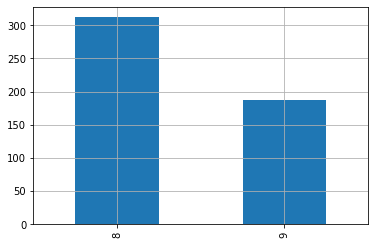

In [16]:
# plot the marginal on nu, throwing away the first half of the data (burn in)
vc = samples['nu'][500:].value_counts().sort_index()
ax = vc.plot(kind='bar')
plt.grid()

# you can get the true distribution for comparison by running a VERY long MCMC chain on the full dataset
# or by exhaustively evaluating (as the parameter space is quite small)